In [1]:
# Re-import necessary libraries after execution reset
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    
    def forward(self, t):
        return self.net(t)

# Define the physics loss function
def loss_function(model, t, omega, x0, v0):
    t.requires_grad = True
    x_theta = model(t)

    dx_dt = torch.autograd.grad(x_theta, t, torch.ones_like(x_theta), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]

    loss_pde = torch.mean((d2x_dt2 + omega**2 * x_theta)**2)
    loss_ic = (model(torch.tensor([[0.0]])) - x0) ** 2 + (dx_dt[0] - v0) ** 2

    return loss_pde + loss_ic

In [ ]:
# Training parameters
omega = 2.0  # Natural frequency sqrt(k/m)
x0 = torch.tensor([[1.0]])  # Initial displacement
v0 = torch.tensor([[0.0]])  # Initial velocity
t_train = torch.rand((50, 1)) * 2  # Reduce training points for efficiency

# Initialize model and optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Training and capturing intermediate results
num_epochs = 1000  # Reduce epochs for efficiency
interval = 10  # Store every 100 epochs
t_test = torch.linspace(0, 2, 100).view(-1, 1)
x_exact = np.cos(omega * t_test.numpy())

train_losses = []
test_predictions = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(model, t_train, omega, x0, v0)
    loss.backward()
    optimizer.step()

    if epoch % interval == 0:
        train_losses.append(loss.item())
        x_pred = model(t_test).detach().numpy()
        test_predictions.append(x_pred)


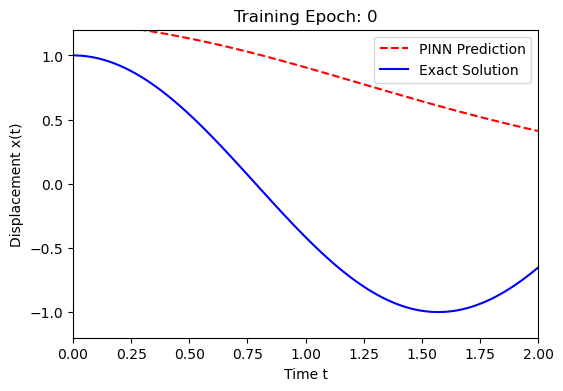

In [3]:
# Create animation of training process
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlim(0, 2)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel("Time t")
ax.set_ylabel("Displacement x(t)")
ax.set_title("Training Progress of PINN")

line_pred, = ax.plot([], [], 'r--', label="PINN Prediction")
line_exact, = ax.plot(t_test.numpy(), x_exact, 'b-', label="Exact Solution")
ax.legend()

def update(frame):
    line_pred.set_data(t_test.numpy(), test_predictions[frame])
    ax.set_title(f"Training Epoch: {frame * interval}")
    return line_pred,

ani = animation.FuncAnimation(fig, update, frames=len(test_predictions), interval=50, blit=False)

# Save the animation as a GIF
gif_path = "pinn_training.gif"
ani.save(gif_path, writer="pillow", fps=10)